## Análise de Gargalos (Bottleneck Analysis) em Processos de Manufatura

**Objetivo:** Utilizar dados de timestamps de um sistema MES (Manufacturing Execution System) para identificar gargalos de produção de forma estatística e analisar como eles mudam sob diferentes condições operacionais.

**Contexto:** Em qualquer linha de produção com múltiplas etapas, a capacidade geral do sistema é ditada pela sua etapa mais lenta. Essa etapa é o **gargalo**. Identificar e otimizar o gargalo é a maneira mais eficaz de aumentar a produção total. Um erro comum é investir em melhorias em etapas que não são o gargalo, o que gera custo sem aumentar significativamente a produção.

**Metodologia:**
1.  Vamos simular dados de um processo com quatro etapas: Corte, Montagem, Pintura e Inspeção.
2.  A partir dos timestamps de início e fim de cada etapa, calcularemos o **Tempo de Processamento** (duração de cada etapa) e o **Tempo de Espera** (tempo em fila entre as etapas).
3.  Analisaremos estatisticamente esses tempos para encontrar o gargalo geral.
4.  Segmentaremos a análise por "Condição Operacional" (no nosso caso, o tipo de produto) para identificar gargalos dinâmicos.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Configurações de visualização
plt.rcParams["figure.figsize"] = (15, 7)

### Simulação de Dados do Sistema MES

Vamos gerar um dataset realista. A lógica da simulação irá criar um **gargalo que muda**: 
- Para o **Produto X**, a **Pintura** será a etapa mais demorada.
- Para o **Produto Y**, a **Montagem** será mais complexa e, portanto, o gargalo.

In [2]:
def simulate_mes_data(n_products=500):
    data = []
    current_time = pd.to_datetime("2025-10-06 08:00:00")

    for i in range(n_products):
        product_type = np.random.choice(["Produto_X", "Produto_Y"])

        # Tempos de processamento em minutos
        t_corte = np.random.normal(10, 1)

        if product_type == "Produto_X":
            t_montagem = np.random.normal(15, 2)
            t_pintura = np.random.normal(30, 5)  # <- Gargalo para Produto X
        else:  # Produto_Y
            t_montagem = np.random.normal(25, 4)  # <- Gargalo para Produto Y
            t_pintura = np.random.normal(12, 2)

        t_inspecao = np.random.normal(8, 1)

        # Tempos de espera (fila) em minutos - o gargalo causa filas antes dele
        wait_montagem = np.random.exponential(1)
        wait_pintura = np.random.exponential(5 if product_type == "Produto_X" else 2)
        wait_inspecao = np.random.exponential(8 if product_type == "Produto_Y" else 3)

        # Gerando os timestamps
        start_corte = current_time
        end_corte = start_corte + timedelta(minutes=t_corte)
        start_montagem = end_corte + timedelta(minutes=wait_montagem)
        end_montagem = start_montagem + timedelta(minutes=t_montagem)
        start_pintura = end_montagem + timedelta(minutes=wait_pintura)
        end_pintura = start_pintura + timedelta(minutes=t_pintura)
        start_inspecao = end_pintura + timedelta(minutes=wait_inspecao)
        end_inspecao = start_inspecao + timedelta(minutes=t_inspecao)

        data.append(
            {
                "id_produto": i + 1,
                "tipo_produto": product_type,
                "start_corte": start_corte,
                "end_corte": end_corte,
                "start_montagem": start_montagem,
                "end_montagem": end_montagem,
                "start_pintura": start_pintura,
                "end_pintura": end_pintura,
                "start_inspecao": start_inspecao,
                "end_inspecao": end_inspecao,
            }
        )

        # O próximo produto só pode começar após o primeiro ter liberado a primeira estação
        current_time = end_corte

    return pd.DataFrame(data)


df = simulate_mes_data(n_products=1000)

print("Amostra dos Dados Brutos do MES:")
df.head()

Amostra dos Dados Brutos do MES:


,id_produto,tipo_produto,start_corte,end_corte,start_montagem,end_montagem,start_pintura,end_pintura,start_inspecao,end_inspecao
0,1,Produto_Y,2025-10-06 08:00:00.000000,2025-10-06 08:09:06.345831,2025-10-06 08:09:10.447386,2025-10-06 08:37:31.620701,2025-10-06 08:38:14.928697,2025-10-06 08:49:50.235698,2025-10-06 08:54:35.359572,2025-10-06 09:03:47.772615
1,2,Produto_X,2025-10-06 08:09:06.345831,2025-10-06 08:18:55.726924,2025-10-06 08:19:11.270753,2025-10-06 08:34:56.258519,2025-10-06 08:44:48.036721,2025-10-06 09:14:10.027674,2025-10-06 09:18:01.667020,2025-10-06 09:25:40.818594
2,3,Produto_Y,2025-10-06 08:18:55.726924,2025-10-06 08:27:10.296746,2025-10-06 08:27:42.948049,2025-10-06 08:53:59.550771,2025-10-06 08:54:01.498150,2025-10-06 09:06:09.569808,2025-10-06 09:11:23.440162,2025-10-06 09:18:19.776367
3,4,Produto_X,2025-10-06 08:27:10.296746,2025-10-06 08:36:33.601418,2025-10-06 08:37:45.037294,2025-10-06 08:56:08.354982,2025-10-06 08:57:22.364192,2025-10-06 09:22:45.888099,2025-10-06 09:26:33.624604,2025-10-06 09:33:55.811549
4,5,Produto_X,2025-10-06 08:36:33.601418,2025-10-06 08:48:17.643790,2025-10-06 08:48:54.324283,2025-10-06 09:02:46.643886,2025-10-06 09:04:40.738938,2025-10-06 09:41:17.112071,2025-10-06 09:41:17.137590,2025-10-06 09:52:04.144880


### Cálculo dos Tempos de Processamento e Espera

Agora, vamos transformar os timestamps brutos em informações úteis: as durações de cada etapa e o tempo de espera entre elas. Todos os valores serão em minutos.

In [3]:
df_proc = pd.DataFrame()
df_proc["id_produto"] = df["id_produto"]
df_proc["tipo_produto"] = df["tipo_produto"]

# Cálculo dos tempos de processamento
df_proc["proc_corte"] = (df["end_corte"] - df["start_corte"]).dt.total_seconds() / 60
df_proc["proc_montagem"] = (
    df["end_montagem"] - df["start_montagem"]
).dt.total_seconds() / 60
df_proc["proc_pintura"] = (
    df["end_pintura"] - df["start_pintura"]
).dt.total_seconds() / 60
df_proc["proc_inspecao"] = (
    df["end_inspecao"] - df["start_inspecao"]
).dt.total_seconds() / 60

# Cálculo dos tempos de espera (fila)
df_proc["espera_montagem"] = (
    df["start_montagem"] - df["end_corte"]
).dt.total_seconds() / 60
df_proc["espera_pintura"] = (
    df["start_pintura"] - df["end_montagem"]
).dt.total_seconds() / 60
df_proc["espera_inspecao"] = (
    df["start_inspecao"] - df["end_pintura"]
).dt.total_seconds() / 60

print("Dados Processados com Tempos de Ciclo e Espera (em minutos):")
df_proc.head()

Dados Processados com Tempos de Ciclo e Espera (em minutos):


,id_produto,tipo_produto,proc_corte,proc_montagem,proc_pintura,proc_inspecao,espera_montagem,espera_pintura,espera_inspecao
0,1,Produto_Y,9.105764,28.352889,11.588450,9.206884,0.068359,0.721800,4.752065
1,2,Produto_X,9.823018,15.749796,29.366516,7.652526,0.259064,9.862970,3.860656
2,3,Produto_Y,8.242830,26.276712,12.134528,6.938937,0.544188,0.032456,5.231173
3,4,Produto_X,9.388411,18.388628,25.392065,7.369782,1.190598,1.233487,3.795608
4,5,Produto_X,11.734040,13.871993,36.606219,10.783455,0.611342,1.901584,0.000425


### Análise de Gargalo Geral

Primeiro, vamos analisar o processo como um todo, sem distinguir os tipos de produto, para encontrar o gargalo médio.

/tmp/ipykernel_40389/1075845598.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Corte", "Montagem", "Pintura", "Inspeção"])
/tmp/ipykernel_40389/1075845598.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["Montagem", "Pintura", "Inspeção"])


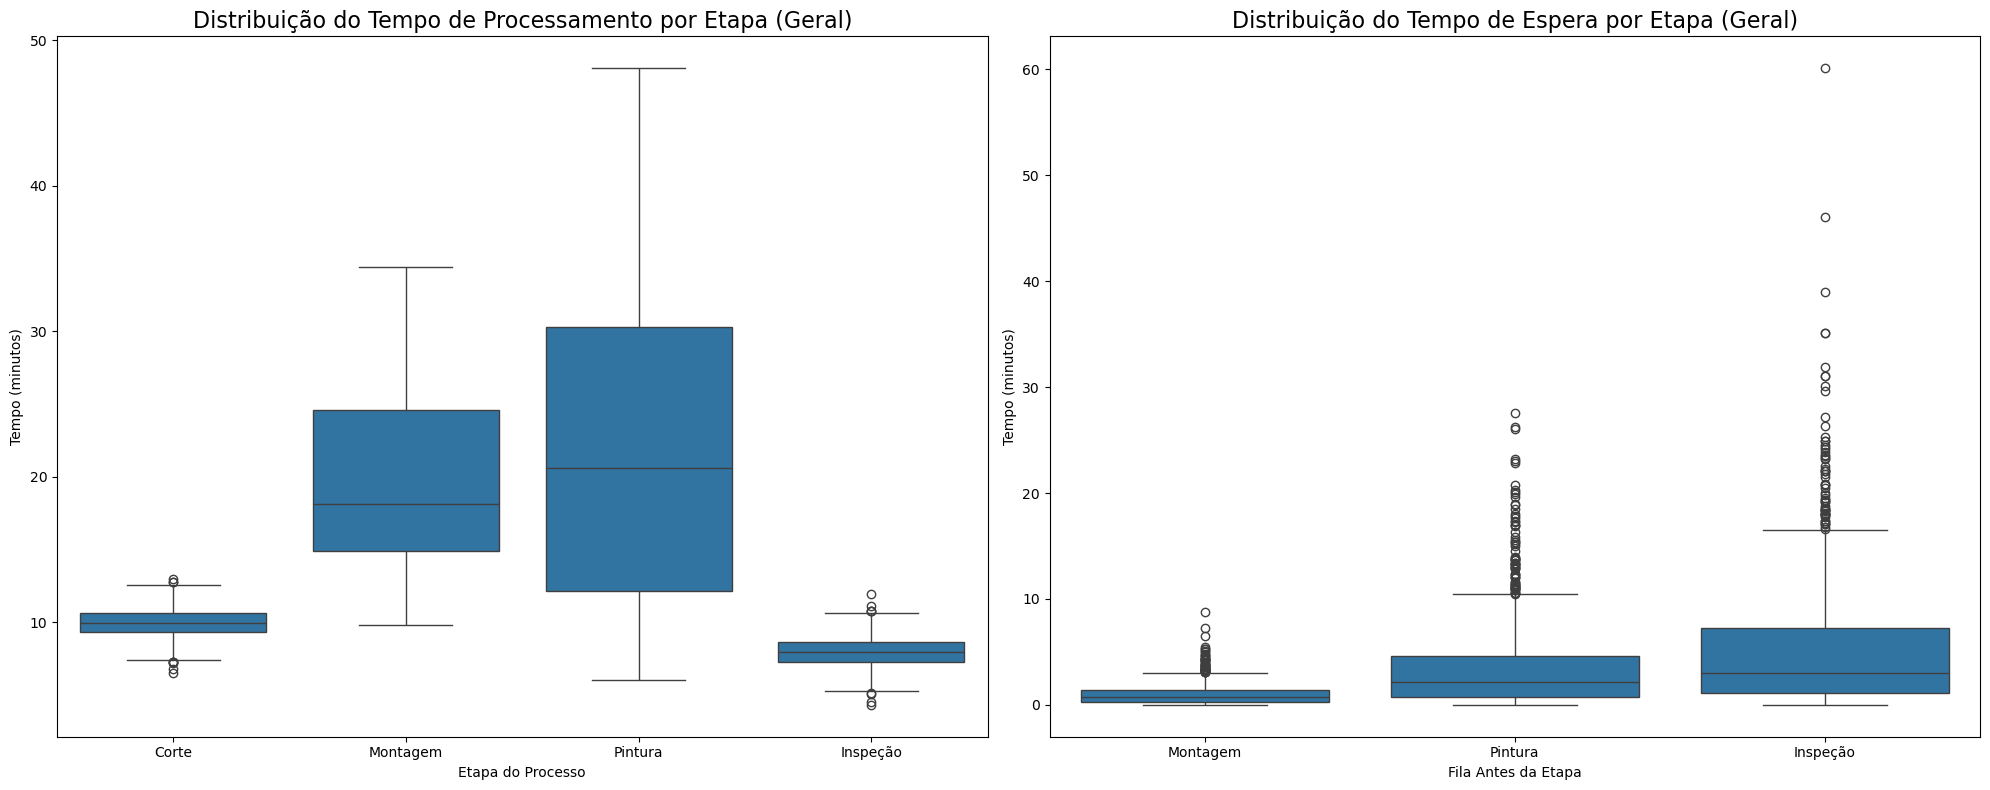

In [4]:
# Preparando os dados para plotagem (formato longo)
proc_times = df_proc.melt(
    id_vars=["id_produto", "tipo_produto"],
    value_vars=["proc_corte", "proc_montagem", "proc_pintura", "proc_inspecao"],
    var_name="etapa",
    value_name="tempo_processamento",
)

wait_times = df_proc.melt(
    id_vars=["id_produto", "tipo_produto"],
    value_vars=["espera_montagem", "espera_pintura", "espera_inspecao"],
    var_name="etapa_seguinte",
    value_name="tempo_espera",
)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Boxplot dos Tempos de Processamento
sns.boxplot(x="etapa", y="tempo_processamento", data=proc_times, ax=axs[0])
axs[0].set_title(
    "Distribuição do Tempo de Processamento por Etapa (Geral)", fontsize=16
)
axs[0].set_xlabel("Etapa do Processo")
axs[0].set_ylabel("Tempo (minutos)")
axs[0].set_xticklabels(["Corte", "Montagem", "Pintura", "Inspeção"])

# Boxplot dos Tempos de Espera
sns.boxplot(x="etapa_seguinte", y="tempo_espera", data=wait_times, ax=axs[1])
axs[1].set_title("Distribuição do Tempo de Espera por Etapa (Geral)", fontsize=16)
axs[1].set_xlabel("Fila Antes da Etapa")
axs[1].set_ylabel("Tempo (minutos)")
axs[1].set_xticklabels(["Montagem", "Pintura", "Inspeção"])

plt.tight_layout()

**Interpretação da Análise Geral:**

- **Tempo de Processamento:** O gráfico da esquerda mostra que, em média, as etapas de `Montagem` e `Pintura` são as mais demoradas, com uma grande variabilidade (caixas mais longas).
- **Tempo de Espera:** O gráfico da direita é ainda mais revelador. Vemos tempos de espera (filas) significativamente maiores antes das etapas de `Pintura` e `Inspeção`. Um tempo de espera alto antes da `Pintura` significa que a Montagem está produzindo mais rápido do que a Pintura consegue absorver.

A análise geral sugere que os gargalos estão em `Montagem` e `Pintura`, mas não nos diz quando cada um deles é o problema. Para isso, precisamos da análise condicional.

### Análise de Gargalo Condicional (por Tipo de Produto)

Agora, vamos segmentar nossa análise para ver como o gargalo muda dependendo do produto que está sendo fabricado. Esta é a análise de maior valor para a gestão da produção.

Tempo Médio de Processamento (min) por Tipo de Produto:


,proc_corte,proc_montagem,proc_pintura,proc_inspecao
tipo_produto,,,,
Produto_X,9.96,15.09,30.09,7.93
Produto_Y,9.95,24.89,12.02,7.95


/tmp/ipykernel_40389/1103788745.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


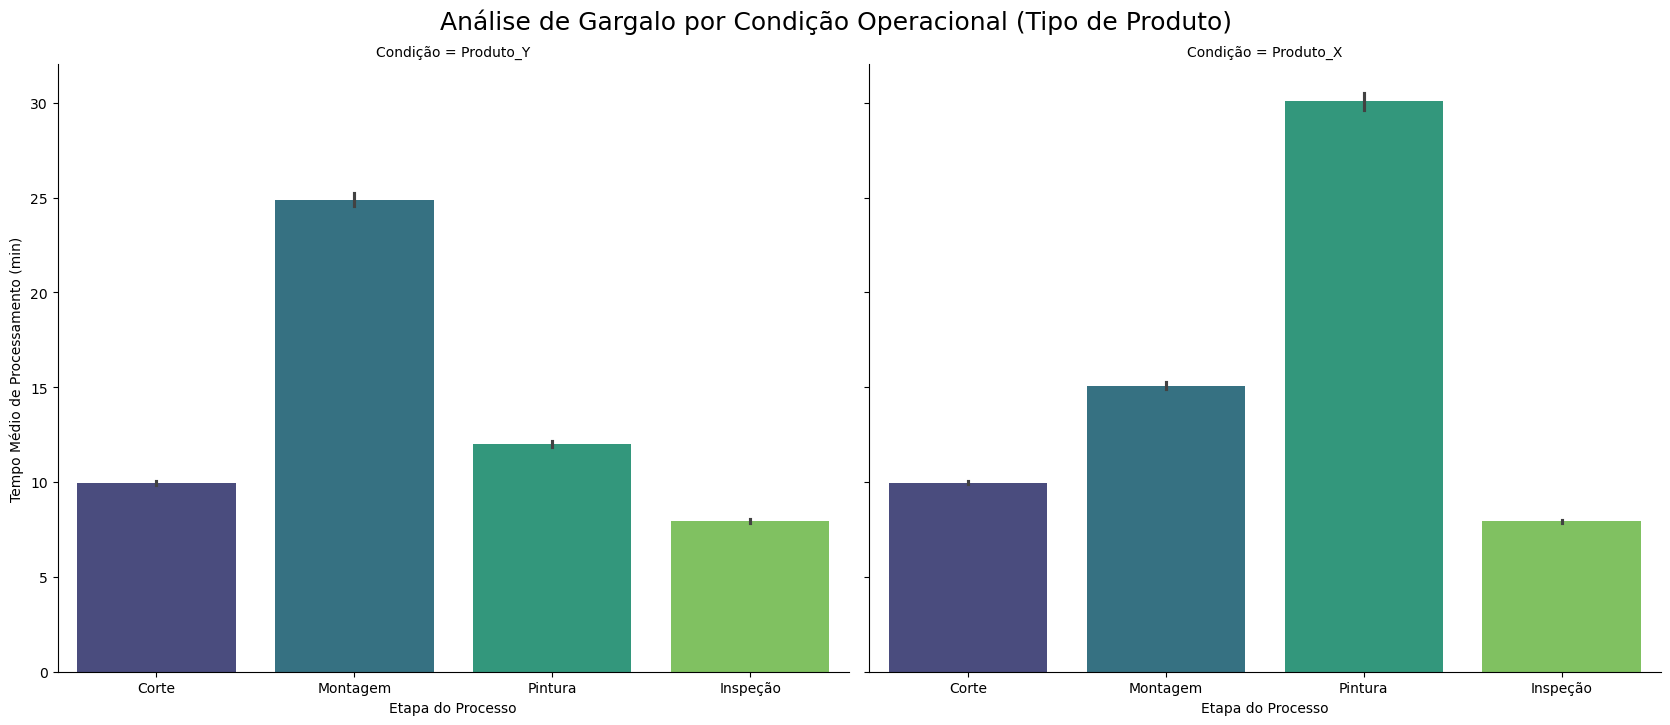

In [5]:
# Calculando a média dos tempos de processamento agrupados por tipo de produto
summary_by_product = df_proc.groupby("tipo_produto")[
    ["proc_corte", "proc_montagem", "proc_pintura", "proc_inspecao"]
].mean()
print("Tempo Médio de Processamento (min) por Tipo de Produto:")
display(summary_by_product.style.format("{:.2f}"))

# --- Visualização Chave: Gráfico de Barras Agrupado ---
g = sns.catplot(
    data=proc_times,
    x="etapa",
    y="tempo_processamento",
    col="tipo_produto",  # Cria um gráfico para cada tipo de produto
    kind="bar",  # ou 'box' para ver a distribuição completa
    height=7,
    aspect=1.2,
    palette="viridis",
)

g.fig.suptitle(
    "Análise de Gargalo por Condição Operacional (Tipo de Produto)", fontsize=18, y=1.03
)
g.set_axis_labels("Etapa do Processo", "Tempo Médio de Processamento (min)")
g.set_xticklabels(["Corte", "Montagem", "Pintura", "Inspeção"])
g.set_titles("Condição = {col_name}")

### Diagnóstico e Insights Acionáveis

**Diagnóstico Final:**

A análise condicional revela a dinâmica real da nossa linha de produção de forma cristalina:

1.  **Para o Produto X:** O gráfico da esquerda mostra que a etapa de **`Pintura`** é, de longe, a mais demorada, com um tempo médio de ~30 minutos. **Este é o gargalo inequívoco quando se produz o Produto X.** Qualquer esforço para acelerar o corte ou a montagem não aumentará a produção final enquanto a pintura não for otimizada.

2.  **Para o Produto Y:** A situação se inverte. O gráfico da direita mostra que a **`Montagem`** se torna a etapa crítica, com um tempo médio de ~25 minutos, enquanto a pintura é relativamente rápida. **A montagem é o gargalo claro para o Produto Y.**

**Insights Acionáveis para a Gestão:**

Esta análise permite que a equipe de engenharia e produção tome decisões baseadas em dados para alocar recursos de melhoria de forma inteligente:

- **Planejamento de Produção:** Ao planejar uma semana de produção focada no `Produto X`, a gestão deve garantir que a equipe de `Pintura` esteja com capacidade máxima, com todos os recursos disponíveis e talvez com mão de obra extra alocada.

- **Projetos de Melhoria Contínua (Kaizen/Lean):**
    - Para melhorar a produção do `Produto X`, os projetos devem focar em **reduzir o tempo de ciclo da pintura**. Perguntas a serem feitas: O tempo de secagem pode ser reduzido? A preparação da peça pode ser mais rápida? Uma nova tecnologia de pintura seria viável?
    - Para o `Produto Y`, os esforços devem se concentrar em **otimizar o processo de montagem**. Perguntas: O layout da estação de montagem é ergonômico? As ferramentas são adequadas? Há falta de componentes causando microparadas? O treinamento da equipe está em dia?

- **Investimentos Estratégicos:** Se a demanda por ambos os produtos for alta, a empresa pode justificar o investimento em uma nova cabine de pintura (para o gargalo do Produto X) e em uma nova estação de montagem automatizada (para o gargalo do Produto Y). A análise quantifica o tempo perdido em cada gargalo, ajudando a calcular o Retorno Sobre o Investimento (ROI) para esses projetos.